### In this notebook, we will forecast the CAQI levels from Jan to Feb 2022 for Warsaw, the capital of Poland. 

In [1]:
import warnings
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor
from statsmodels.tsa.seasonal import MSTL
from tqdm.auto import tqdm

sns.set(style="ticks", palette="muted", color_codes=True)

warnings.filterwarnings("ignore")

plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 20

seed = 42

In [2]:
train = pd.read_parquet("train_temporal_regression.parquet.gz")
test = pd.read_parquet("test_temporal_regression.parquet.gz")

#Combining to create whole dataset and filtering warsaw powiat
full_df = pd.concat([train, test]).query("powiat_voivod=='powiat warszawa, mazowieckie'")

In [3]:
full_df.head()

,powiat_voivod,cloud_cover,wind_speed,humidity,precipitation,snow_depth,temperature,voivodship,animal stock - total,area by land - utilised agricultural area,...,season,CAQI_lag1,holiday_name,is_school_holiday,is_lockdown,is_have_coalplant,rolling7_CAQI,rolling30_CAQI,rolling90_CAQI,is_weekend
DATE,,,,,,,,,,,,,,,,,,,,,
2017-01-01,"powiat warszawa, mazowieckie",5.6,11.142857,91.75,0.0,0.0,1.44,mazowieckie,44.470019,0.987198,...,Winter,55.140000,New Year's Day,0.0,0.0,1.0,55.140000,37.222143,62.378746,1
2017-01-02,"powiat warszawa, mazowieckie",7.8,51.000000,79.00,8.0,0.0,0.94,mazowieckie,44.470019,0.987198,...,Winter,55.140000,Non Holiday,0.0,0.0,1.0,55.140000,37.222143,62.378746,0
2017-01-03,"powiat warszawa, mazowieckie",6.4,12.857143,92.50,66.8,1.0,-0.84,mazowieckie,44.470019,0.987198,...,Winter,52.330000,Non Holiday,0.0,0.0,1.0,53.735000,37.222143,62.378746,0
2017-01-04,"powiat warszawa, mazowieckie",7.6,67.000000,88.75,35.2,3.6,1.20,mazowieckie,44.470019,0.987198,...,Winter,26.811111,Non Holiday,0.0,0.0,1.0,44.760370,37.222143,62.378746,0
2017-01-05,"powiat warszawa, mazowieckie",5.6,35.142857,74.75,0.0,5.0,-6.36,mazowieckie,44.470019,0.987198,...,Winter,17.770000,Non Holiday,0.0,0.0,1.0,38.012778,37.222143,62.378746,0


# Preparing Forecasting dataset for Warsaw

In [4]:
#For easier creation of forecast df containign dates from Jan 2022 to Jan 2023, 
#I will first grab a subset of old data from Jan 2017 to Jan 2018 and then replace the years with
#Forecasting years
forecast_df = full_df.loc["2017-01-01" : "2018-01-31"]

In [5]:
#replace 2017 with 2022 and 2018 with 2023
forecast_df.index=\
[pd.to_datetime(str(ix).replace("2017", "2022").replace("2018", "2023")) for ix in forecast_df.index]

In [6]:
#Geting the right year and dayofweek
forecast_df['year'] = forecast_df.index.year
forecast_df['dayofweek'] = forecast_df.index.dayofweek

forecast_df['is_weekend'] = np.where(forecast_df['dayofweek'].isin([5, 6]), 1, 0)

In [7]:
#Except these cols, rest will be replaced with null values
exclude_cols = [
    'powiat_voivod', 'voivodship', 'isUrban', 'day', 'month', 'year', 'dayofweek', 'season', 
    'is_lockdown', 'is_have_coalplant', 'is_weekend'
]

forecast_df[[col for col in forecast_df.columns if col not in exclude_cols]] = np.nan

In [8]:
#Getting holidays for 2022 and 2023

holiday_df = pd.read_csv("datasets/poland_holidays.csv", parse_dates=['date'], index_col='date')

forecast_df.loc[forecast_df.index.isin(holiday_df.index), 'holiday_name'] = \
holiday_df.loc[holiday_df.index.isin(pd.date_range("2022-01-01", "2023-01-31")), 'holiday_name']

In [9]:
forecast_df['holiday_name'] = forecast_df['holiday_name'].fillna("Non Holiday")

### School holidays

In [10]:
#Geting school holidays for warsaw
def get_school_holidays(year):

    df = pd.read_html(f"https://www.holidays-info.com/poland/school-holidays/{year}/")[0].\
             rename(columns={"Unnamed: 0" : "voivod"}).query("voivod=='Mazovia'")
    
    df['voivod'] = df['voivod'].replace("Mazovia", "mazowieckie")
    
    for col in ['Winter', 'Spring', 'Summer', 'Christmas']:
        df[col]=\
        df[col].str.split(" - ").str[0] + f", {year}" + " - " + \
        df[col].str.split(" - ").str[1] + f", {year}"
        
    return df

In [11]:
school_hol_df = pd.concat((get_school_holidays(year=year) for year in [2022, 2023]), ignore_index=True)

school_hol_df

,voivod,Winter,Spring,Summer,Christmas
0,mazowieckie,"Jan 31, 2022 - Feb 13, 2022","Apr 14, 2022 - Apr 19, 2022","Jun 25, 2022 - Aug 31, 2022","Dec 23, 2022 - Dec 31, 2022"
1,mazowieckie,"Feb 13, 2023 - Feb 26, 2023","Apr 6, 2023 - Apr 11, 2023","Jun 24, 2023 - Aug 31, 2023","Dec 23, 2023 - Dec 31, 2023"


In [12]:
for col in ['Winter', 'Spring', 'Summer', 'Christmas']:
    for date in school_hol_df[col]:
        
        start = date.split(" - ")[0]
        end = date.split(" - ")[1]

        daterange = pd.date_range(start, end, freq='D')

        forecast_df.loc[forecast_df.index.isin(daterange), "is_school_holiday"] = 1

forecast_df['is_school_holiday'] = forecast_df['is_school_holiday'].fillna(0)
forecast_df['is_school_holiday'].unique()

array([0., 1.])

# Merging to make wholedataset

In [13]:
warsaw_df = pd.concat([full_df, forecast_df])

In [14]:
static_cols=\
list(
    warsaw_df.loc[
:, 'animal stock - total' : 'crop production - permanent pastures, area in ha, total'
    ].columns
)

### Extrapolating static cols

In [15]:
#https://stackoverflow.com/a/68579584/15937542
warsaw_df[static_cols] = warsaw_df[static_cols].interpolate(method="slinear", fill_value="extrapolate")

# Warsaw weather data (Jan 2022 to Jan 2023)

In [16]:
weather_df = \
pd.read_csv("datasets/Combined_weather_data_forecasting.csv", parse_dates=['DATE'], index_col='DATE').\
    drop("Unnamed: 0", axis=1)

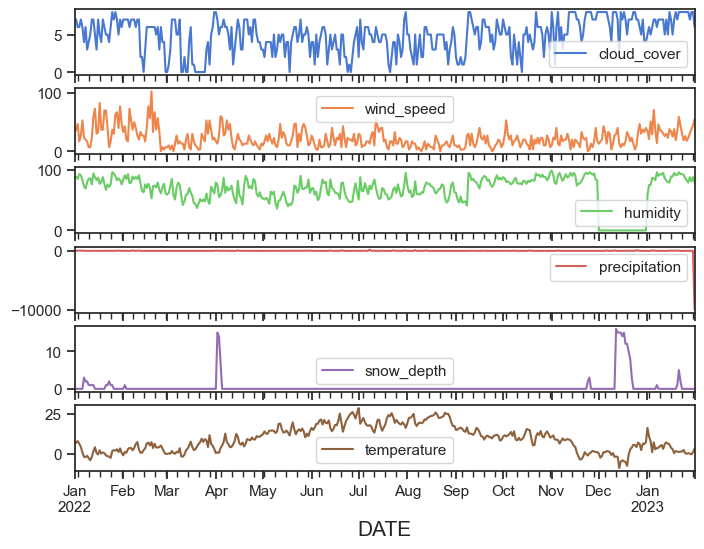

In [17]:
weather_cols=['cloud_cover', 'wind_speed', 'humidity', 'precipitation', 'snow_depth', 'temperature']

weather_df[weather_cols].plot(subplots=True, figsize=(8, 6));

Both humidity and precipitation have some outliers, will handle them.

In [18]:
#Replacing 0 humidity with null and then imputing with MSTL
weather_df.loc[weather_df['humidity'].eq(0), 'humidity']=np.nan

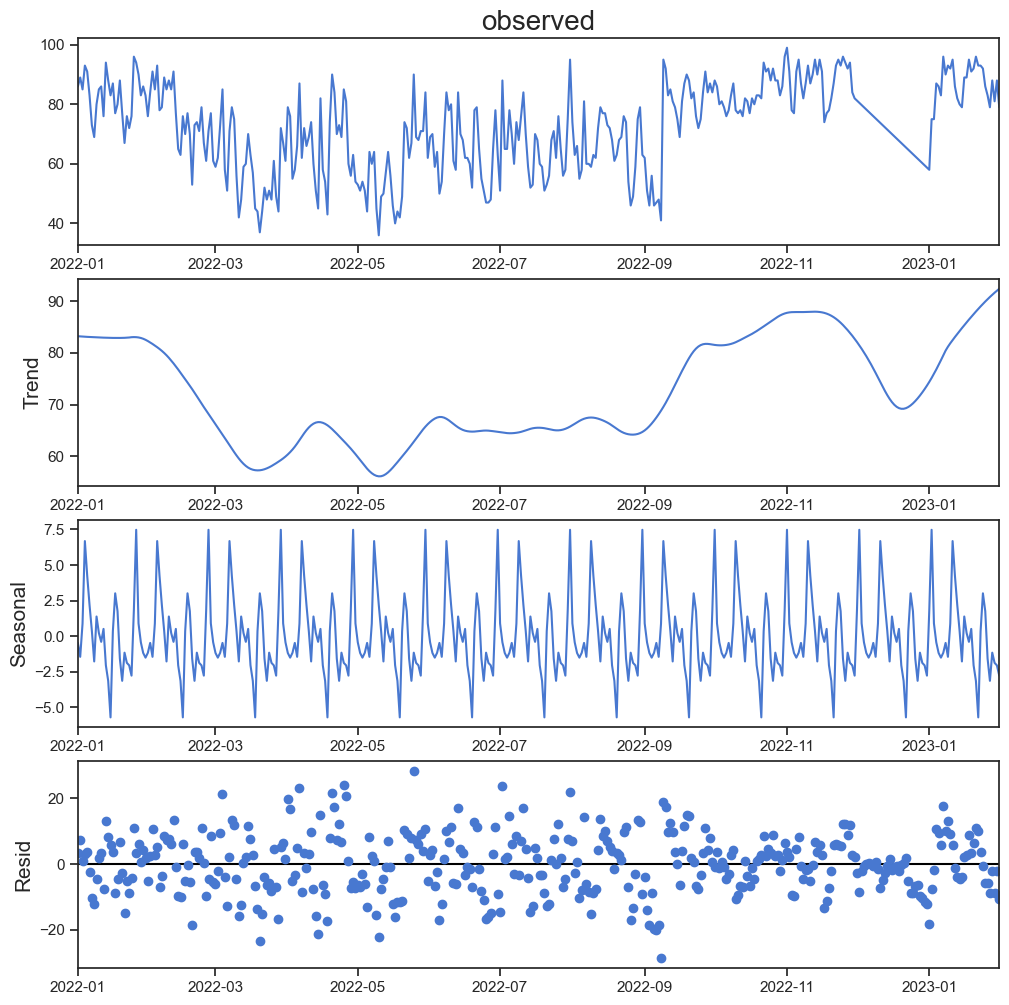

In [19]:
null_values = weather_df['humidity'].isna()
    
#First imputation using linear interpolation
temp_df = weather_df['humidity'].interpolate('linear')

#Creating MSTL
mstl = MSTL(temp_df, 
        periods=(31), #monthly seasonality
        windows=[1001],
        stl_kwargs={
            "seasonal_deg":0, # Means the seasonal smoother is fit with a moving average.
           }
       )

res=mstl.fit()

plt.rc("figure", figsize=(10, 10))
plt.rc("font", size=5)
res.plot();

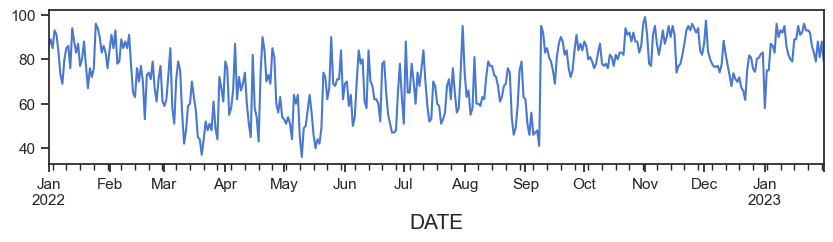

In [20]:
#imputting missing values
weather_df.loc[null_values, 'humidity'] = \
res.seasonal.loc[null_values] + res.trend.loc[null_values] - res.resid.loc[null_values]

weather_df['humidity'].plot(figsize=(10, 2));

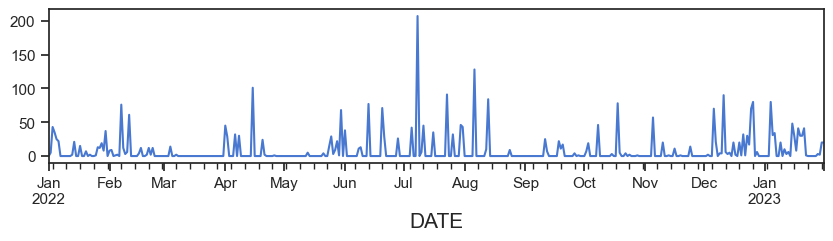

In [21]:
#Handling outlier in precipitation
weather_df.loc[weather_df['precipitation'].lt(0), 'precipitation'] = np.nan

weather_df['precipitation'] = weather_df['precipitation'].ffill()
weather_df['precipitation'].plot(figsize=(10, 2));

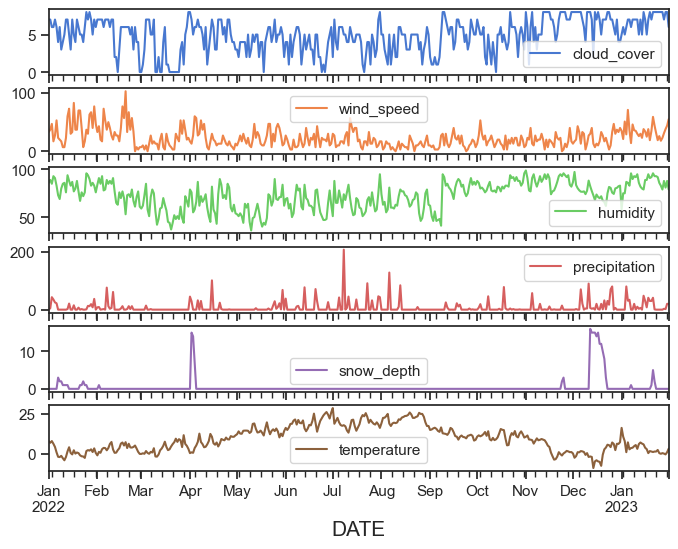

In [22]:
#Final check
weather_df[weather_cols].plot(subplots=True, figsize=(8, 6));

In [23]:
#Replacing empty weather data
warsaw_df.loc["2022-01-01" : , weather_cols] = weather_df[weather_cols]

In [24]:
#These cols will be dropped later in the pipeline, so just filling missing values with 0 for now.
warsaw_df[["rolling90_CAQI", "rolling7_CAQI"]] = warsaw_df[["rolling90_CAQI", "rolling7_CAQI"]].fillna(0)

In [25]:
#Removing all other dataset
del weather_df, train, test, full_df, holiday_df

In [26]:
#Checking remaining null values
warsaw_df.isnull().sum()[warsaw_df.isnull().sum()!=0]

CAQI_idx          396
CAQI_lag1         396
rolling30_CAQI    396
dtype: int64

# Forecasting

In [27]:
#Trained XGboost pipeline
with open("final_model.pkl", "rb") as r:
    model = pickle.load(r)

For each date, we will need the lag1 CAQI value and rolling 30day mean CAQI value. The prediction will be done iteratively.

In [28]:
for date in tqdm(pd.date_range("2022-01-01", "2023-01-31")): 
    
    #Lag1 CAQI_idx
    warsaw_df.loc[date, "CAQI_lag1"] = warsaw_df.loc[pd.to_datetime(date)-pd.offsets.Day(1), 'CAQI_idx']
    
    #30day rolling mean
    warsaw_df.loc[date, "rolling30_CAQI"]=\
    warsaw_df.loc[
        pd.to_datetime(date)-pd.offsets.Day(30) : pd.to_datetime(date)-pd.offsets.Day(1), 'CAQI_idx'
    ].mean()
    
    #Preparing independent values
    X = warsaw_df.loc[[date]].drop("CAQI_idx", axis=1)
    
    #Predicting
    warsaw_df.loc[date, "CAQI_idx"] = model.predict(X)[0]

  0%|          | 0/396 [00:00<?, ?it/s]

# Compare with actual CAQI

In [29]:
pollutant_df=\
pd.read_csv("datasets/Combined_pollutant_data_forecasting.csv", parse_dates=['DATE'], index_col='DATE')

pollutant_df.head()

,NO2,O3,PM10,PM25,powiat_voivod
DATE,,,,,
2022-01-01,11.554348,47.203261,15.333540,5.933913,"powiat warszawa, mazowieckie"
2022-01-02,14.889583,40.460417,11.352976,11.816667,"powiat warszawa, mazowieckie"
2022-01-03,20.019792,43.171875,10.525595,8.278333,"powiat warszawa, mazowieckie"
2022-01-04,31.255027,27.600000,14.016071,12.991667,"powiat warszawa, mazowieckie"
2022-01-05,25.662500,41.594792,11.952976,12.261667,"powiat warszawa, mazowieckie"


In [30]:
#From Parnika's Notebook
def find_CAQI(no_conc, o3_conc, pm10_conc, pm25_conc):
    
    default_indx_value=101;
    result_indx=dict();  

    caqi_index_levels_map= {1:[0,25],2:[25,50],3:[50,75],4:[75,100],5:[100,]}

    # Calculate NO2 sub-index and its level
    if not pd.isna(no_conc):
        if ((no_conc>=0) and (no_conc<=50)):
            target_indx=caqi_index_levels_map.get(1)
            no=np.interp(no_conc,[0,50],[target_indx[0],target_indx[1]])
        
        elif((no_conc>50) and (no_conc<=100)):
            target_indx=caqi_index_levels_map.get(2)
            no=np.interp(no_conc,[50,100],[target_indx[0],target_indx[1]])
            
        elif((no_conc>100) and (no_conc<=200)):  
            target_indx=caqi_index_levels_map.get(3)
            no=np.interp(no_conc,[100,200],[target_indx[0],target_indx[1]])
            
        elif((no_conc>200) and (no_conc<=400)):  
            target_indx=caqi_index_levels_map.get(4)
            no=np.interp(no_conc,[200,400],[target_indx[0],target_indx[1]])
            
        else:
            no=default_indx_value
    else:
        no=np.nan    

    result_indx['NO2_sub_idx'] = no
    
    # Calculate O3 sub-index
    if not pd.isna(o3_conc):
        if ((o3_conc>=0) and (o3_conc<=60)):
            target_indx=caqi_index_levels_map.get(1)
            o3=np.interp(o3_conc,[0,60],[target_indx[0],target_indx[1]])
        
        elif((o3_conc>60) and (o3_conc<=120)):
            target_indx=caqi_index_levels_map.get(2)
            o3=np.interp(o3_conc,[60,120],[target_indx[0],target_indx[1]])
        
        elif((o3_conc>120) and (o3_conc<=180)):  
            target_indx=caqi_index_levels_map.get(3)
            o3=np.interp(o3_conc,[120,180],[target_indx[0],target_indx[1]])
            
        elif((o3_conc>180) and (o3_conc<=240)):  
            target_indx=caqi_index_levels_map.get(4)
            o3=np.interp(o3_conc,[180,240],[target_indx[0],target_indx[1]])
        else:
            o3=default_indx_value
    else:
        o3=np.nan   

    result_indx['O3_sub_idx'] = o3      

    # Calculate PM10 sub-index
    if not pd.isna(pm10_conc):
        if ((pm10_conc>=0) and (pm10_conc<=25)):
            target_indx=caqi_index_levels_map.get(1)
            pm10=np.interp(pm10_conc,[0,25],[target_indx[0],target_indx[1]])
    
        elif((pm10_conc>25) and (pm10_conc<=50)):
            target_indx=caqi_index_levels_map.get(2)
            pm10=np.interp(pm10_conc,[25,50],[target_indx[0],target_indx[1]])
    
        elif((pm10_conc>50) and (pm10_conc<=90)):  
            target_indx=caqi_index_levels_map.get(3)
            pm10=np.interp(pm10_conc,[50,90],[target_indx[0],target_indx[1]])
    
        elif((pm10_conc>90) and (pm10_conc<=180)):  
            target_indx=caqi_index_levels_map.get(4)
            pm10=np.interp(pm10_conc,[90,180],[target_indx[0],target_indx[1]])
        
        else:
            pm10=default_indx_value
    else:
        pm10=np.nan

    result_indx['PM10_sub_idx'] = pm10
    
    # Calculate PM25 sub-index
    if not pd.isna(pm25_conc):
        if ((pm25_conc>=0) and (pm25_conc<=15)):
            target_indx=caqi_index_levels_map.get(1)
            pm25=np.interp(pm25_conc,[0,15],[target_indx[0],target_indx[1]])
    
        elif((pm25_conc>15) and (pm25_conc<=30)):
            target_indx=caqi_index_levels_map.get(2)
            pm25=np.interp(pm25_conc,[15,30],[target_indx[0],target_indx[1]])
    
        elif((pm25_conc>30) and (pm25_conc<=55)):  
            target_indx=caqi_index_levels_map.get(3)
            pm25=np.interp(pm25_conc,[30,55],[target_indx[0],target_indx[1]])
    
        elif((pm25_conc>55) and (pm25_conc<=110)):  
            target_indx=caqi_index_levels_map.get(4)
            pm25=np.interp(pm25_conc,[55,110],[target_indx[0],target_indx[1]])
        
        else:
            pm25=default_indx_value
    else:
        pm25=np.nan

    result_indx['PM25_sub_idx'] = pm25
    
    # Find poorest (highest) index value among available pollutats
    caqi_indx=np.nanmax(np.array([no, o3, pm10, pm25]))
    result_indx['CAQI_idx'] = caqi_indx  

    # Find CAQI index level
    if not pd.isna(caqi_indx):
        if ((caqi_indx>=0) and (caqi_indx<=25)):
            caqi='vlow'
        
        elif((caqi_indx>25) and (caqi_indx<=50)):
            caqi='low'
    
        elif((caqi_indx>50) and (caqi_indx<=75)):  
            caqi='medium'
    
        elif((caqi_indx>75) and (caqi_indx<=100)):  
            caqi='high'
        
        else:
            caqi='vhigh'
    else:
        caqi=''

    result_indx['CAQI_level'] = caqi  

    #print(caqi_indx)
    #print(caqi)

    return result_indx

In [31]:
def iterate_data_frame(df):
    for i, row in df.iterrows():
        if (pd.isna(row['NO2']) and pd.isna(row['O3']) and pd.isna(row['PM10']) and pd.isna(row['PM25'])):
            df.loc[i, 'CAQI_idx']=math.nan
            df.loc[i, 'CAQI_level']=''

        else:
            result=find_CAQI(row['NO2'], row['O3'], row['PM10'], row['PM25'])
            df.loc[i, 'NO2_sub_idx']=result['NO2_sub_idx']
            df.loc[i, 'O3_sub_idx']=result['O3_sub_idx']
            df.loc[i, 'PM10_sub_idx']=result['PM10_sub_idx']
            df.loc[i, 'PM25_sub_idx']=result['PM25_sub_idx']
            df.loc[i, 'CAQI_idx']=result['CAQI_idx']
            df.loc[i, 'CAQI_level']=result['CAQI_level']  

In [32]:
%%time
iterate_data_frame(df=pollutant_df)

Wall time: 331 ms


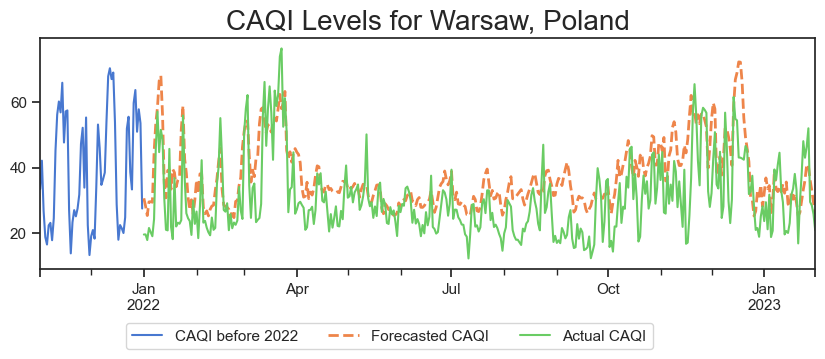

In [33]:
ax = warsaw_df.loc["2021-11-01" : "2021-12-31", "CAQI_idx"].plot(figsize=(10, 3));

warsaw_df.loc["2022-01-01" : , "CAQI_idx"].plot(ax=ax, linestyle="--", lw=2);

pollutant_df['CAQI_idx'].plot(ax=ax);

ax.set_xlabel("")
ax.set_title("CAQI Levels for Warsaw, Poland")
ax.legend(labels=["CAQI before 2022", "Forecasted CAQI", "Actual CAQI"], ncol=3, 
          bbox_to_anchor=(0.8, -0.2));

In [34]:
rmse = mean_squared_error(pollutant_df['CAQI_idx'], 
                          warsaw_df.loc["2022-01-01" : , "CAQI_idx"], 
                          squared=False)

print(f"Actual vs Forecast CAQI RMSE: {rmse:.3f}")

Actual vs Forecast CAQI RMSE: 10.424


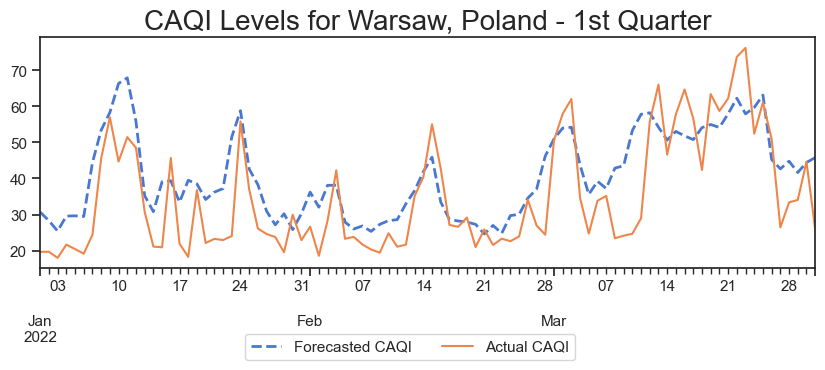

In [35]:
#1st Quarter
ax = warsaw_df.loc["2022-01-01" : "2022-03-31", "CAQI_idx"].plot(linestyle="--", lw=2, figsize=(10, 3));

pollutant_df.loc["2022-01-01" : "2022-03-31", 'CAQI_idx'].plot(ax=ax);

ax.set_xlabel("")
ax.set_title("CAQI Levels for Warsaw, Poland - 1st Quarter")
ax.legend(labels=["Forecasted CAQI", "Actual CAQI"], ncol=3, bbox_to_anchor=(0.7, -0.25));

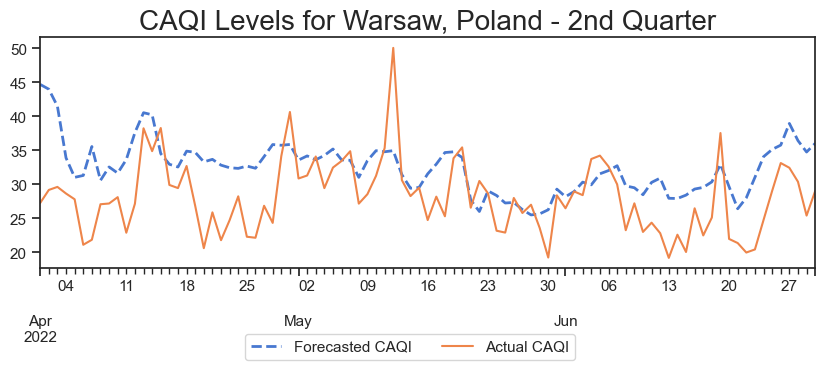

In [36]:
#2nd Quarter
ax = warsaw_df.loc["2022-04-01" : "2022-06-30", "CAQI_idx"].plot(linestyle="--", lw=2, figsize=(10, 3));

pollutant_df.loc["2022-04-01" : "2022-06-30", 'CAQI_idx'].plot(ax=ax);

ax.set_xlabel("")
ax.set_title("CAQI Levels for Warsaw, Poland - 2nd Quarter")
ax.legend(labels=["Forecasted CAQI", "Actual CAQI"], ncol=3, bbox_to_anchor=(0.7, -0.25));

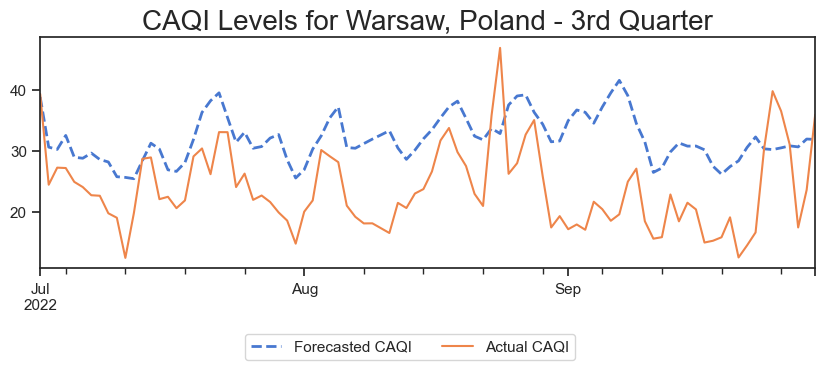

In [37]:
#3rd Quarter
ax = warsaw_df.loc["2022-07-01" : "2022-09-30", "CAQI_idx"].plot(linestyle="--", lw=2, figsize=(10, 3));

pollutant_df.loc["2022-07-01" : "2022-09-30", 'CAQI_idx'].plot(ax=ax);

ax.set_xlabel("")
ax.set_title("CAQI Levels for Warsaw, Poland - 3rd Quarter")
ax.legend(labels=["Forecasted CAQI", "Actual CAQI"], ncol=3, bbox_to_anchor=(0.7, -0.25));

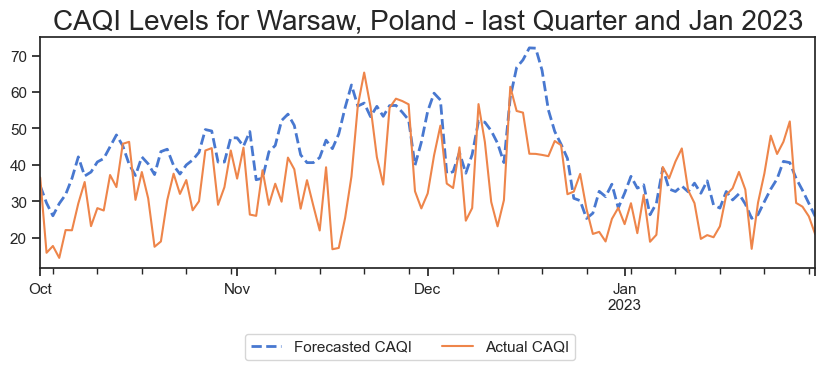

In [38]:
#last Quarter and Jan 2023
ax = warsaw_df.loc["2022-10-01" : , "CAQI_idx"].plot(linestyle="--", lw=2, figsize=(10, 3));

pollutant_df.loc["2022-10-01" : , 'CAQI_idx'].plot(ax=ax);

ax.set_xlabel("")
ax.set_title("CAQI Levels for Warsaw, Poland - last Quarter and Jan 2023")
ax.legend(labels=["Forecasted CAQI", "Actual CAQI"], ncol=3, bbox_to_anchor=(0.7, -0.25));

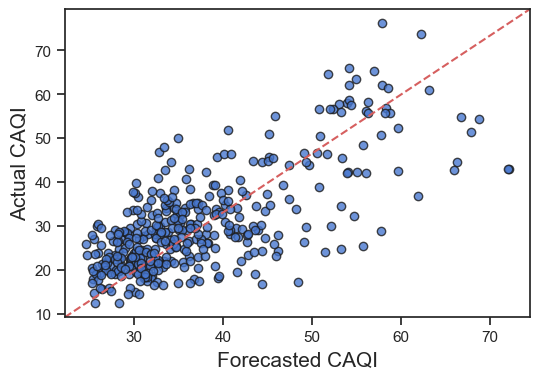

In [39]:
#Plotting Forecasted vs Actual CAQI scatterplot
fig, ax = plt.subplots(figsize=(6, 4))

ax.scatter(
    x=warsaw_df.loc["2022-01-01" : , "CAQI_idx"],
    y=pollutant_df['CAQI_idx'],
    edgecolor='k',
    alpha=0.8
)

ax.set_ylabel("Actual CAQI")
ax.set_xlabel("Forecasted CAQI")
ax.plot([0, 1], [0, 1], transform=ax.transAxes, color='r', ls='--');